<a href="https://colab.research.google.com/github/Bhuvanesh-Singla/Emojimation_Bhuvanesh_Version/blob/main/_Copy_of_task1_v2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow import keras
from keras import Sequential
from keras import layers, models
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

In [2]:
# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')
!rm -rf data
!mkdir data
os.chdir('data')
!pwd

# Download data
!pip install -q kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!pwd
!ls
# Unzip data
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip train.csv test.csv

kaggle.json
/content/data
 96% 273M/285M [00:03<00:00, 96.9MB/s]
100% 285M/285M [00:03<00:00, 75.7MB/s]
/content/data
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: test.csv                
  inflating: train.csv               


In [3]:
data = pd.read_csv('train.csv')
print(data.head(5))

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
import csv
import numpy

train_images = []
train_labels = []
categories_count = {}

with open('train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


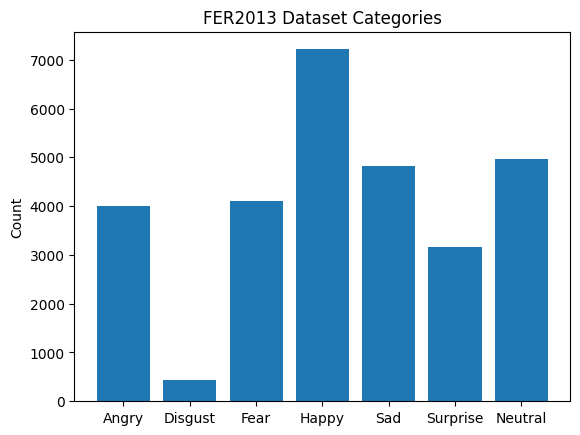

In [5]:
categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = numpy.arange(len(categories))

counts = []
for label in range(len(categories)):
    label_str = str(label)
    count = categories_count[label_str]
    counts.append(count)

# Draw histogram
plt.bar(y_pos, counts, align='center')
plt.xticks(y_pos, categories)
plt.ylabel('Count')
plt.title('FER2013 Dataset Categories')

plt.show()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1,random_state = 42)
x_train, x_test , x_val= x_train / 255.0, x_test / 255.0, x_val / 255.0

x_train = x_train.reshape(len(x_train), 48, 48, 1)
x_test = x_test.reshape(len(x_test), 48, 48, 1)
x_val = x_val.reshape(len(x_val),48,48,1)
print(x_train.shape)
print(x_test.shape)

(23254, 48, 48, 1)
(2871, 48, 48, 1)


In [7]:
from keras.utils import to_categorical

In [8]:
datagen = ImageDataGenerator(height_shift_range = 0.3,
                            width_shift_range = 0.2,
                            rotation_range = 40,
                            horizontal_flip = True,
                             )

In [9]:
cnn = models.Sequential([
    layers.Conv2D(filters=64, kernel_size = (3,3),activation = 'relu', padding = 'same',input_shape =(48,48,1) ),
    layers.Conv2D(filters=64, kernel_size = (3,3),activation = 'relu',padding = 'same' ),
    layers.Conv2D(filters=64, kernel_size = (3,3),activation = 'relu',padding = 'same'),
    layers.MaxPooling2D((2,2),strides = 2),
    
    layers.Conv2D(filters=128, kernel_size = (3,3),activation = 'relu' , padding = 'same'),
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D((2,2), strides = 2),
    
    layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    layers.MaxPool2D((2,2), strides = 2),
    
    layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    layers.MaxPool2D((2,2), strides = 2),

    layers.Flatten(),
    layers.Dense(4096, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(2048, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation = 'softmax')
])

In [10]:
cnn.compile(
    optimizer = Adam(learning_rate=0.00005),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [11]:
callback = EarlyStopping(
    monitor = 'loss',
    min_delta = 0.0001,
    patience = 5,
    verbose = 1,
    restore_best_weights=True
)

In [12]:
train_generator = datagen.flow(
    x_train,
    y = y_train,
    batch_size = 32
)

In [13]:
# val_generator = datagen.flow(
#     x_val,
#     y = y_val,
#     batch_size = 32
# )

In [14]:
test_generator = datagen.flow(
    x_test,
    y = y_test,
    batch_size = 32
)

In [ ]:
history = cnn.fit(train_generator, epochs = 1000, shuffle = True, validation_data=(x_val, y_val), callbacks=callback)

In [28]:
test_loss, test_acc = cnn.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

90/90 [==============================] - 1s 12ms/step - loss: 2.6184 - accuracy: 0.6607
Test accuracy: 0.66074538230896


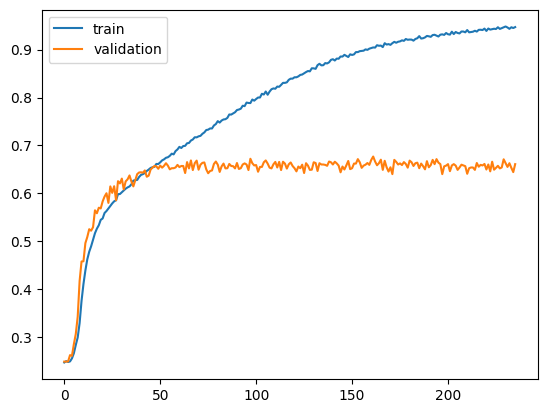

In [19]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.legend()
plt.show()